# density estimation using diffusion models

1. We will experiment to generate simple distributions over 2 dimensions using diffusion models
2. Following we will try to generate class conditioned distribution based on a simple labelling strategy

C:\Users\varun\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-20.0, 20.0)

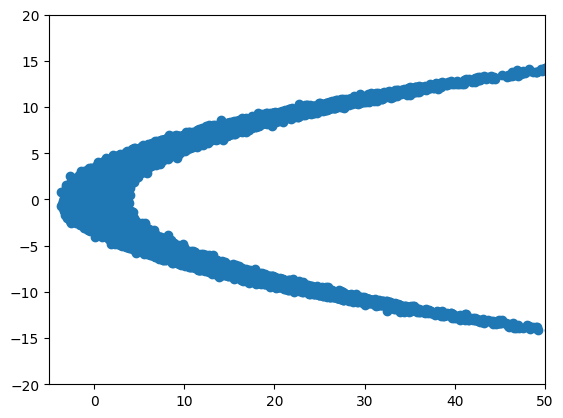

In [ ]:
# create a dataset of 10K points, sampled from some complex distribution

import torch
from matplotlib import pyplot as plt

samples = 1024*128
x = torch.normal(mean=0, std=4, size=(1, samples))
y = torch.normal(mean=0.25*torch.ones(samples)*x*x, std=torch.ones(samples)*1)

plt.scatter(y,x)
plt.xlim([-5, 50])
plt.ylim([-20, 20])

(-1.0, 1.0)

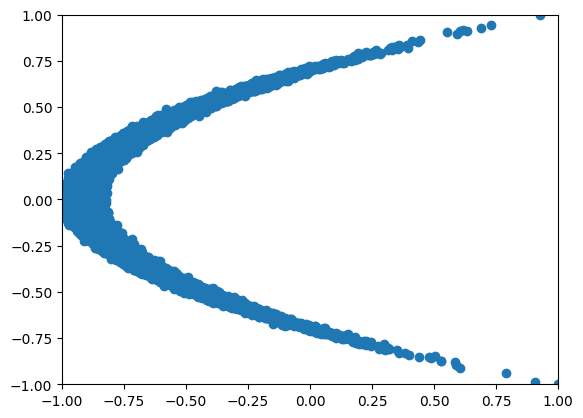

In [ ]:
# transform to range
data = torch.vstack([y, x])

def transform(data):
    min_, max_ = torch.min(data, axis=1), torch.max(data, axis=1)
    data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    return data_transformed, min_, max_

data_transformed, min_, max_ = transform(data)
plt.scatter(data_transformed[0], data_transformed[1])
plt.xlim([-1, 1])
plt.ylim([-1, 1])

(-20.0, 20.0)

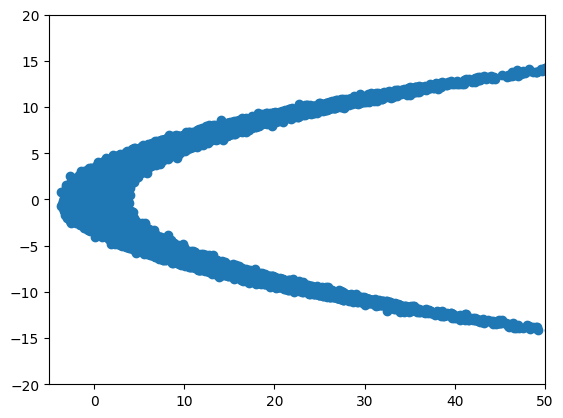

In [ ]:
def reverse_transform(data_transformed, min_, max_):
    # data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    data = (data_transformed + 1).mul((max_.values - min_.values)[:, None]).add(min_.values[:, None]*2)/2
    return data
    
data = reverse_transform(data_transformed, min_, max_)
plt.scatter(data[0], data[1])
plt.xlim([-5, 50])
plt.ylim([-20, 20])

In [ ]:
# train model

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.25
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

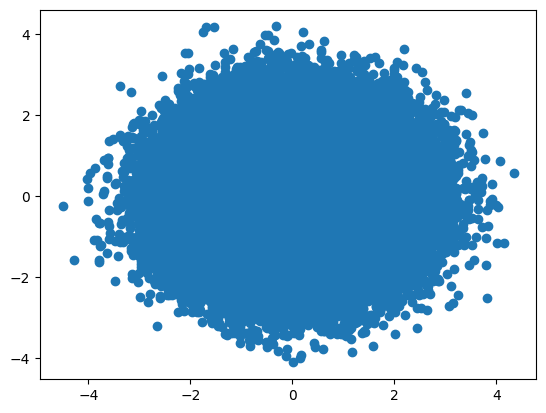

In [ ]:
# Train model
timesteps = 200
# betas = linear_beta_schedule(timesteps)
betas = linear_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = torch.sqrt(variance)

import torch.nn.functional as F

alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)

# how to add noise of the data
def get_noisy(batch, timestep):
    added_noise_at_t = torch.normal(batch*torch.sqrt(alphas_[timestep]), std=sd[timestep])
    return added_noise_at_t
    
# def reverse_noisy(batch_pred, timestep):

added_noise_at_t = get_noisy(data_transformed, timesteps-1)
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (1 - alphas) * (1 - alphas_prev_) / (1 - alphas)

In [ ]:
torch.var_mean(data_transformed, dim=1), torch.var_mean(added_noise_at_t, dim=1)

((tensor([0.0181, 0.0501]), tensor([-0.8206,  0.0028])),
 (tensor([1.0003, 0.9973]), tensor([-0.0016, -0.0045])))

In [ ]:
torch.sqrt(torch.Tensor([1., 1.])*alphas_[49])

tensor([0.4547, 0.4547])

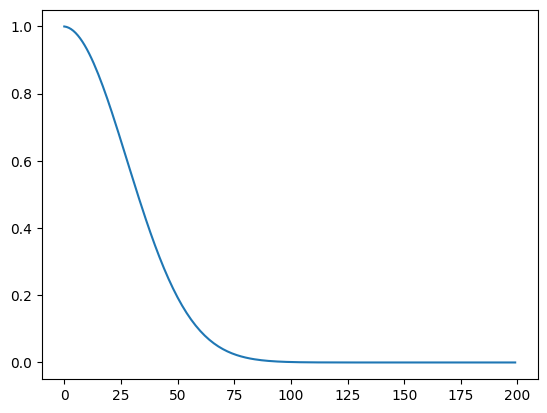

In [ ]:
plt.plot(alphas_)

# building a model

A 3 layer NN with 8 units each followed by a 2 layer output for x0 data point

In [ ]:
learning_rate = 1e-3
batch_size = 2048
epochs = 1

from torch import nn

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()
        
        self.fc4 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()
        
        self.fc7 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)
        
        return x
      
denoising_model = DenoisingModel()
print(denoising_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU()
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (activation3): GELU()
  (fc4): Linear(in_features=3, out_features=32, bias=True)
  (activation4): GELU()
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU()
  (fc6): Linear(in_features=32, out_features=3, bias=True)
  (activation6): GELU()
  (fc7): Linear(in_features=3, out_features=32, bias=True)
  (activation7): GELU()
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU()
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)


loss: 0.091013  [   10/ 2048]
tensor([[-0.2734,  0.0768],
        [-0.2731,  0.0765],
        [-0.2731,  0.0765],
        [-0.2733,  0.0767],
        [-0.2731,  0.0764],
        [-0.2732,  0.0767],
        [-0.2731,  0.0764],
        [-0.2732,  0.0766],
        [-0.2733,  0.0768],
        [-0.2731,  0.0764]]) tensor([[-0.8982,  0.0957],
        [-0.8002, -0.2191],
        [-0.9606,  0.0774],
        [-0.7122,  0.3143],
        [-0.9315, -0.0820],
        [-0.8106,  0.1972],
        [-0.7681,  0.3025],
        [-0.8765, -0.1372],
        [-0.7413,  0.3334]])


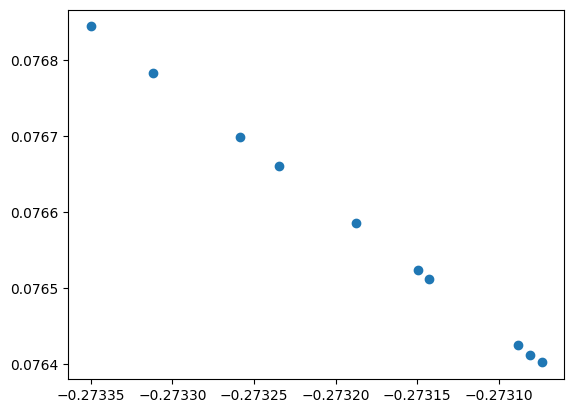

In [ ]:
##### testing neural network above

test_noise_step = 5
data_noisy = get_noisy(data_transformed[:, 0:10], test_noise_step)
# torch.hstack([data_noisy, torch.Tensor(5)])
t_ = torch.Tensor([test_noise_step])
t_ = t_.repeat(10)
data_noisy = torch.vstack([data_noisy, t_])

with torch.no_grad():
    for epoch in range(1, epochs+1):
        data_pred = denoising_model(data_noisy.T)
        loss_ = loss_func(data_transformed[:, 0:10].T, data_pred)
        # loss_.backward()
        # optimizer.step()
        loss, current = loss_.item(), 1 * 10
        print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    
print(data_pred, data_transformed[:, 1:10].T)

plt.scatter(data_pred.T[0], data_pred.T[1])

In [ ]:
import os
import os.path as osp
from copy import deepcopy
import pickle
import sys

epochs = 400

def train_model(denoising_model, data_transformed, model_name, train_new_model=False):
    best_loss = sys.float_info.max
    ff = osp.join(os.getcwd(), 'saved_models', 'best', model_name + '_state.pkl')
    if not train_new_model:
        if os.path.exists(osp.join(os.getcwd(), 'saved_models', 'best', model_name + '.pt')):
            denoising_model = torch.load(osp.join(os.getcwd(), 'saved_models', 'best', model_name + '.pt'))
            with open(ff, 'rb') as fp:
                data_noisy, pred_data, data_in_batch, timestep, losses = pickle.load(fp)
            return data_noisy, pred_data, data_in_batch, timestep, losses
    losses = []
    for epoch in range(1, epochs+1):
        for n in range(1, int(len(data_transformed[0])/batch_size) + 1):
        # for n in range(1, 1000):
            data_in_batch = data_transformed[:, (n-1)*batch_size:(n*batch_size)]
            idx = torch.randint(0, timesteps-1, (batch_size, )).long()
            timestep = idx.add(1)
            data_noisy = get_noisy(data_in_batch, timestep)
            optimizer.zero_grad(set_to_none=True)
            data_noisy_stacked = torch.vstack([data_noisy, timestep])
            pred_data = denoising_model(data_noisy_stacked.T)
            imp_weight = torch.sqrt(1/2 * ((alphas_prev_[timestep] / (1 - alphas_prev_[timestep])) - (alphas_[timestep]/(1 - alphas_[timestep]))))
            # loss on prediction
            loss_ = loss_func(data_in_batch.mul(imp_weight), pred_data.T.mul(imp_weight))
            # norm = tensor.norm(pred_data.sub(data_noisy), dim=0)
            # loss = loss_*norm
            loss_.backward()
            optimizer.step()
        ## evaluating noise on a fixed timestep to calculate best model
        
        with torch.no_grad():
            one_timestep = torch.Tensor([1]).repeat(batch_size).long()
            data_noisy_temp = get_noisy(data_in_batch, one_timestep)
            data_noisy_stacked_temp = torch.vstack([data_noisy_temp, one_timestep])
            pred_data_temp = denoising_model(data_noisy_stacked_temp.T)
            # loss on prediction
            loss_temp = loss_func(data_in_batch.mul(1), pred_data_temp.T.mul(1))
            losses.append(loss_temp.item())
            
        if loss_temp.item() < best_loss:
            best_loss = loss_temp.item()
            print(f"saving epoch: {epoch} loss: {best_loss:>7f}")
            torch.save(deepcopy(denoising_model.state_dict()), osp.join(os.getcwd(), 'saved_models', 'best', model_name + '.pt'))
            with open(ff, 'wb') as fp:
                pickle.dump([data_noisy, pred_data, data_in_batch, timestep, losses], fp, protocol=pickle.HIGHEST_PROTOCOL)
                
        if epoch % 20 == 0:
            loss = loss_temp.item()
            print(f"epoch: {epoch} loss: {loss:>7f}")

    if os.path.exists(osp.join(os.getcwd(), 'saved_models', 'best', model_name + '.pt')):
        denoising_model = torch.load(osp.join(os.getcwd(), 'saved_models', 'best', model_name + '.pt'))
        with open(ff, 'rb') as fp:
            data_noisy, pred_data, data_in_batch, timestep, losses = pickle.load(fp)
        return data_noisy, pred_data, data_in_batch, timestep, losses
    
data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'denoising_model')

saving epoch: 1 loss: 0.016586


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\varun\\research\\density_estimation\\saved_models\\best\\denoising_model.pt'

In [ ]:
plt.plot(torch.Tensor(losses))

In [ ]:
plt.scatter(data_noisy[0], data_noisy[1])

In [ ]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

In [ ]:
data_in_batch[:10], pred_data[:10].T, timestep[:10]

# generation of data

In [ ]:
def generate_data(denoising_model):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 2048*5
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    data_noisy =  torch.normal(mean=0, std=1, size=(2, batch_size_generation))
    # data_noisy_x =  torch.normal(mean=mean_last_step[0], std=std_last_step[0], size=(1, batch_size_generation))

    # data_noisy = torch.vstack([data_noisy_x, data_noisy_y])


    datas = []
    datas.append(data_noisy.cpu().detach())
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, timesteps):
            timestep = timesteps-t
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, t_repeated])
            pred_data = denoising_model(data_stacked.T)
            mean_data_1 = data_in_batch.T.mul(torch.sqrt(alphas[timestep])*(1-alphas_prev_[timestep])/(variance[timestep]))
            mean_data_2 = pred_data.mul(torch.sqrt(alphas_prev_[timestep])*(1-alphas[timestep])/(variance[timestep]))
            mean_data = mean_data_1.add(mean_data_2)
            posterior_data = posterior_variance[timestep]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).T
            datas.append(data_in_batch.cpu().detach())
    return datas, data_in_batch

datas, data_in_batch = generate_data(denoising_model)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data[0], data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-10, 100])
ax1.set_ylim([-20, 20])

ax2.set_xlim([-10, 100])
ax2.set_ylim([-20, 20])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

# trying out different sklearn moon distributions

In [ ]:
from sklearn import datasets
from matplotlib import pyplot as plt

circles, _ = datasets.make_circles(1024*128, noise=0.01, factor=0.1, shuffle=True)
circles = circles* [5., 10.] 
circles = circles.T
plt.scatter(circles[0], circles[1])

In [ ]:
make_moons, labels = datasets.make_moons(n_samples=1024*128, noise=0.01)
make_moons = make_moons* [5., 10.] 
make_moons = make_moons.T
plt.scatter(make_moons[0], make_moons[1])

In [ ]:
import numpy

complex_data = numpy.hstack([make_moons + 15, circles ]) 
numpy.random.shuffle(complex_data.T)

plt.scatter(complex_data[0], complex_data[1])

#### train models

In [ ]:
make_circles_model = DenoisingModel(128)
print(make_circles_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_circles_model.parameters(), lr=learning_rate)

circles = torch.Tensor(circles)
circles_normalized, min_circles, max_circles = transform(circles)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_circles_model, circles_normalized, 'make_circles_model')
plt.plot(torch.Tensor(losses))

In [ ]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

In [ ]:
temp = get_noisy(circles, 1)
plt.scatter(temp[0], temp[1])

In [ ]:
datas, data_in_batch = generate_data(make_circles_model)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_circles, max_circles)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(circles[0], circles[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 5])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 5])
ax2.set_ylim([-10, 10])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

#### make moons

In [ ]:
make_moons_model = DenoisingModel(128)
print(make_moons_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_moons_model.parameters(), lr=learning_rate)

make_moons = torch.Tensor(make_moons)
make_moons_normalized, min_moons, max_moons = transform(make_moons)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_moons_model, make_moons_normalized, 'make_moons_model')
plt.plot(torch.Tensor(losses))

In [ ]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

In [ ]:
temp = get_noisy(make_moons, 1)
plt.scatter(temp[0], temp[1])

In [ ]:
datas, data_in_batch = generate_data(make_moons_model)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_moons, max_moons)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(make_moons[0], make_moons[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 10])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 10])
ax2.set_ylim([-10, 10])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

#### complex data distribution

In [ ]:
make_complex_model = DenoisingModel(128)
print(make_complex_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_complex_model.parameters(), lr=learning_rate)

complex_data = torch.Tensor(complex_data)
complex_data_normalized, min_complex, max_complex = transform(complex_data)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_complex_model, complex_data_normalized, 'make_complex_model')
plt.plot(torch.Tensor(losses))

In [ ]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

In [ ]:
# complex_data = torch.Tensor(complex_data)
# complex_data_normalized, min_complex, max_complex = transform(complex_data)

temp = get_noisy(complex_data_normalized, 0)
plt.scatter(temp[0], temp[1])

In [ ]:
datas, data_in_batch = generate_data(make_complex_model)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_complex, max_complex)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(complex_data[0], complex_data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 25])
ax1.set_ylim([-10, 30])

ax2.set_xlim([-5, 25])
ax2.set_ylim([-10, 30])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])